## Описание решения

In [77]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from operator import itemgetter, attrgetter
import random
import pickle
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import importlib
import sn_graph_functions as gf
importlib.reload(gf)
import predictor as pred
importlib.reload(pred)

<module 'predictor' from 'G:\\Develop\\Repositories\\VK_test\\version3\\predictor.py'>

In [78]:
# Реализация расчета данных метрик взята из библиотеки ml_metrics 

def apk(actual, predicted, k):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [79]:
data = pd.read_csv('data/friends_dataset', sep=',', header = None, names=['id1','id2','time','intensity'])
super_social_users = pd.DataFrame(data['id1'].value_counts())
quant = super_social_users['id1'].quantile(0.75)
super_social_users = list(super_social_users[super_social_users['id1']>=quant].index)

In [80]:
train_data = pred.load_from_pickle("data/train_data_shuffled")
test_data = pred.load_from_pickle("data/test_data_with_negatives")
train_graph = nx.read_gpickle("data/train_graph")
undir_graph = train_graph.to_undirected()

In [81]:
# уберем из обучения слишком социально активных
train_data = train_data[np.isin(train_data[:, -3], super_social_users, invert=True)]
test_data = test_data[np.isin(test_data[:, -3], super_social_users, invert=True)]

In [82]:
train_data.shape, test_data.shape

((768549, 10), (39210, 10))

In [83]:
users_list = list(set(test_data[:,-3].astype(int)))
ids1 = test_data[:, -3].astype(int)
ids2 = test_data[:, -2].astype(int)

In [84]:
X_train = train_data[:,:-3]
y_train = train_data[:,-1]

X_test = test_data[:,:-3]
y_test = test_data[:,-1]

In [85]:
X_train.shape, X_test.shape

((768549, 7), (39210, 7))

In [86]:
train_data.shape, X_train.shape, y_train.shape

((768549, 10), (768549, 7), (768549,))

In [87]:
test_data.shape, X_test.shape, y_test.shape

((39210, 10), (39210, 7), (39210,))

In [88]:
y_train[y_train==0].shape, y_train[y_train==1].shape

((432863,), (335686,))

#### Логрегрессия. ROC AUC считаем по тестовой выборке

In [90]:
scaler = StandardScaler()  
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

In [91]:
clf_lr = LogisticRegression(solver='lbfgs', random_state=110)
clf_lr.fit(X_train, y_train)

predictions = clf_lr.predict_proba(X_test)
predictions = predictions[:,list(clf_lr.classes_).index(1)]
roc_auc_score(y_test, predictions)

0.8223465757212539

In [92]:
model = {'estimator':clf_lr, 'scaler':scaler}
pred.save_to_pickle(model, 'data/model_lr')

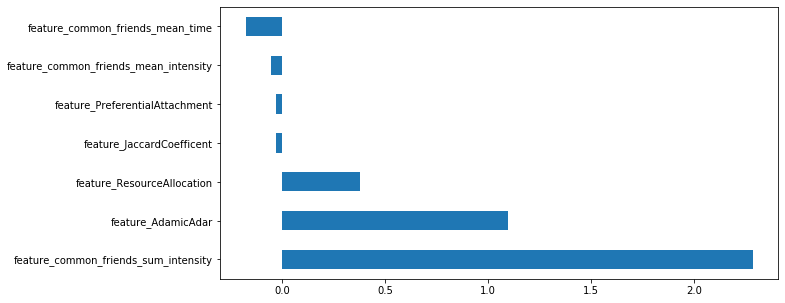

In [93]:
# Посмотрим веса признаков
features = ['feature_common_friends_mean_intensity','feature_common_friends_sum_intensity','feature_common_friends_mean_time',
            'feature_AdamicAdar','feature_ResourceAllocation','feature_JaccardCoefficent','feature_PreferentialAttachment']
feature_importances = dict(zip(features, clf_lr.coef_[0]))
pd.Series(feature_importances).nlargest(100).plot(kind='barh', figsize=(10, 5))

#### RandomForest. ROC AUC считаем по тестовой выборке

In [95]:
%%time
clf_rf = RandomForestClassifier(bootstrap=True,
            max_depth=15, n_estimators=50, n_jobs=-1, random_state=110,
            warm_start=True)

clf_rf.fit(X_train, y_train)

predictions = clf_rf.predict_proba(X_test)
predictions = predictions[:,list(clf_rf.classes_).index(1)]
roc_auc_score(y_test, predictions)

Wall time: 30.3 s


0.8303174512931158

In [96]:
model = {'estimator':clf_rf, 'scaler':scaler}
pred.save_to_pickle(model, 'data/model_rf')

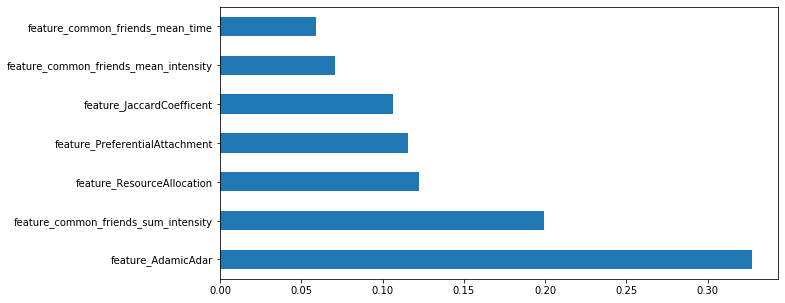

In [97]:
# Посмотрим важности признаков
features = ['feature_common_friends_mean_intensity','feature_common_friends_sum_intensity','feature_common_friends_mean_time',
            'feature_AdamicAdar','feature_ResourceAllocation','feature_JaccardCoefficent','feature_PreferentialAttachment']

feature_importances = dict(zip(features, clf_rf.feature_importances_))
pd.Series(feature_importances).nlargest(100).plot(kind='barh', figsize=(10, 5))

In [98]:
model

{'estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=15, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                        oob_score=False, random_state=110, verbose=0,
                        warm_start=True),
 'scaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

#### Запускаем модель так как это будет происходить в production-версии - с предварительным отбором кандидатов.
#### Считать будем метрику MAP@5

In [110]:
# Удалим отрицательные примеры

X_test = X_test[y_test==1]
test_data = test_data[y_test==1]
y_test = y_test[y_test==1]
users_list = list(set(test_data[:,-3].astype(int)))
ids1 = test_data[:, -3].astype(int)
ids2 = test_data[:, -2].astype(int)

In [101]:
X_test.shape, y_test.shape

((29936, 7), (29936,))

In [102]:
model_type = 'rf'

if model_type == 'rf':
    clf = pred.load_from_pickle('data/model_rf')['estimator']
    scaler = pred.load_from_pickle('data/model_rf')['scaler']
elif model_type == 'lr':
    clf = pred.load_from_pickle('data/model_lr')['estimator']
    scaler = pred.load_from_pickle('data/model_lr')['scaler']
else:
    print('Unknown model type')


In [103]:
predictions_proba=clf.predict_proba(X_test)
predictions=clf.predict(X_test)

In [104]:
predictions_df = pd.DataFrame()
predictions_df['id1'] = ids1
predictions_df['id2'] = ids2
predictions_df['proba'] = predictions_proba[:,list(clf.classes_).index(1)]
predictions_df['prediction'] = predictions
predictions_df['answer'] = y_test

In [105]:
predictions_df.head()

,id1,id2,proba,prediction,answer
0,1933661,4149852,0.302276,0.0,1.0
1,6971914,2539987,0.168742,0.0,1.0
2,1252111,9784949,0.976588,1.0,1.0
3,8419036,3969992,0.478781,0.0,1.0
4,999577,5741626,0.302276,0.0,1.0


In [ ]:
%%time
answers_all = []
predictions_all = []
k = 5

for user in users_list:
    user_df = predictions_df[predictions_df['id1']==user]
    user_df = user_df.sort_values(by='proba', ascending=False)
    predictions_all.append(pred.recommend(user_identifier=user, graph=train_graph, undir_graph=undir_graph, 
                                          estimator=clf, scaler=scaler, k=k, pre_selection_type=2, pre_selection_k=30))
    answers_all.append(list(user_df[user_df['answer']==1]['id2']))
    
#     if len(predictions_all) % 100 == 0:
#         print(len(predictions_all))

# print('MAP@{} = {}'.format(k,mapk(answers_all, predictions_all, k=k)))   

In [111]:
print('MAP@{} = {}'.format(k,mapk(answers_all, predictions_all, k=k))) 

MAP@5 = 0.20329097916035926


#### Baseline-решение

In [108]:
%%time
answers_all_v0 = []
predictions_all_v0 = []
k = 5

for user in users_list:
    user_df = predictions_df[predictions_df['id1']==user]
    predictions_all_v0.append(gf.recommend_by_common_friends_count(user, train_graph, k))
    answers_all_v0.append(list(user_df[user_df['answer']==1]['id2']))

print('MAP@{} = {}'.format(k,mapk(answers_all_v0, predictions_all_v0, k=k))) 

MAP@5 = 0.18777411948733477
Wall time: 39.7 s
